---
 # **Automated Ripeness Detection of Fruits using Deep Learning**
---

## 1. Importing Necessary Modules and Libraries

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, VGG19, Xception
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

2025-05-14 13:14:50.152040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747228490.343273      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747228490.408197      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Class Definitions

### 2.1 Configuration

In [2]:
class Configuration:
    def __init__(self):
        self.data_dir = '/kaggle/input/fruits-ripeness-classification-dataset/'
        self.image_size = (224,224)
        self.batch_size = 32
        self.num_classes = 3
        self.optimizer = Adam
        self.learning_rate = 0.001
        self.epochs = 20
        self.loss = CategoricalCrossentropy()
        self.metrics = ['categorical_accuracy', 'precision', 'recall', 'auc']

### 2.2 DataLoader

In [3]:
class DataLoader:
    def __init__(self, data_dir, validation_split=0.1):
        self.train_dir = os.path.join(data_dir, 'Train')
        self.test_dir = os.path.join(data_dir, 'Test')
        
        self.train_datagen = ImageDataGenerator(rescale=1./255,
                                                validation_split=validation_split,
                                                rotation_range=30.0,
                                                width_shift_range=0.1,
                                                height_shift_range=0.1,
                                                shear_range=0.1,
                                                zoom_range=0.1,
                                                horizontal_flip=True,
                                                brightness_range=[0.8,1.2]
                                               )
        self.test_datagen = ImageDataGenerator(rescale=1./255)
        
    def get_training_data(self, image_size=(224,224), batch_size=32):
        print('Loading Training Data')
        train_generator = self.train_datagen.flow_from_directory(self.train_dir,
                                                                 target_size = image_size,
                                                                 class_mode = 'categorical',
                                                                 batch_size = batch_size,
                                                                 subset = 'training'
                                                                )
        print('Loading Validation Data')
        validation_generator = self.train_datagen.flow_from_directory(self.train_dir,
                                                                      target_size = image_size,
                                                                      class_mode = 'categorical',
                                                                      batch_size = batch_size,
                                                                      shuffle = True,
                                                                      subset = 'validation'
                                                                     )
        return train_generator, validation_generator
    
    def get_testing_data(self, image_size=(224,224), batch_size=32):
        print('Loading Test Data')
        test_generator = self.test_datagen.flow_from_directory(self.test_dir,
                                                               target_size = image_size,
                                                               class_mode = 'categorical',
                                                               batch_size = batch_size,
                                                               shuffle = False
                                                              )
        return test_generator

### 2.3 Visualizer

In [4]:
class Visualizer:
    def __init__(self):
        pass
        
    def pieplot(self, subplot, data, title):
        classes, count = np.unique(data.classes, return_counts=True)
        labels = data.class_indices.keys()
        subplot.pie(count, labels=labels, autopct='%.1f%%')
        subplot.set_title(title)
        
    def show_data_distribution(self, train, validation, test):
        fig, axes = plt.subplots(1,3, figsize=(12, 6))
        
        self.pieplot(axes[0], train, 'Training set')
        self.pieplot(axes[1], validation, 'Validation set')
        self.pieplot(axes[2], test, 'Test set')
        
        plt.show()
        
    def show_confusion_matrix(self, y_true, y_pred, labels):
        cm = confusion_matrix(y_true, y_pred)
        cm_df = pd.DataFrame(cm,
                             index = labels,
                             columns = labels
                            )
        sns.heatmap(cm_df,
                    annot=True,
                    cbar=False,
                    fmt='g',
                    cmap="viridis"
                   )
        plt.title('Confusion Matrix')
        plt.ylabel('Actal Values')
        plt.xlabel('Predicted Values')
        plt.show()
        
    def show_classification_report(self, y_true, y_pred, labels):
        print("Classification Report")
        print("===========================================\n")
        print(classification_report(y_true, y_pred, target_names=labels ))

### 2.4 PretrainedModel

In [5]:
class PretrainedModel(Model):
    def __init__(self, image_size, num_classes, base_model, **kwargs):
        super(PretrainedModel, self).__init__(**kwargs)
        
        self.image_size = image_size
        self.input_shape = image_size + (3,)
        self.num_classes = num_classes
        self.inputs = Input(shape=self.input_shape)
        self.base_model = base_model(weights='imagenet',
                                     include_top=False,
                                     input_shape=self.input_shape,
                                    )
        self.avg_pool = GlobalAveragePooling2D()
        self.dense_1 = Dense(256, activation='relu', name='new_dense_1')
        self.dense_2 = Dense(128, activation='relu', name='new_dense_2')
        self.dropout = Dropout(0.2)
        self.output_layer = Dense(self.num_classes, activation='softmax', name='new_output')
        
        self.build_graph(self.input_shape)
    
    def build(self, input_shape):
        super(PretrainedModel, self).build(input_shape)
        
        
    def build_graph(self, input_shape):
        self.build(input_shape)
        _ = self.call(self.inputs)
        
    def freeze_layers(self):
        for layer in self.base_model.layers:
            layer.trainable = False
        self.base_model.trainable = False
        
    def call(self, inputs, training=False):
        self.freeze_layers()
        
        x = self.base_model(inputs)
        x = self.avg_pool(x)
        x = self.dense_1(x)
        x = self.dropout(x, training=training)
        x = self.dense_2(x)
        x = self.output_layer(x)
        
        return x

## 3. Initialization

In [6]:
#tf.keras.utils.set_random_seed = 500

conf = Configuration()
dataloader = DataLoader(conf.data_dir)
visualizer = Visualizer()

### 3.1 Hyperparameters

In [7]:
conf.image_size = (224,224)
conf.learning_rate = 0.01
conf.batch_size = 32
conf.epochs = 20

## 4. Loading Dataset

### 4.1 Training and Validation Data

In [8]:
train_gen, val_gen = dataloader.get_training_data(image_size=conf.image_size, batch_size=conf.batch_size)

Loading Training Data
Found 3992 images belonging to 3 classes.
Loading Validation Data
Found 442 images belonging to 3 classes.


### 4.2 Testing Data

In [9]:
test_gen = dataloader.get_testing_data(image_size=conf.image_size, batch_size=conf.batch_size)

Loading Test Data
Found 180 images belonging to 3 classes.


### 4.3 Data Distribution

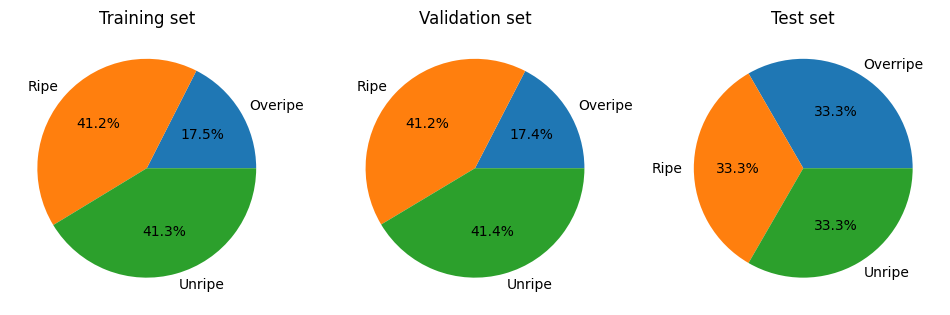

In [10]:
visualizer.show_data_distribution(train_gen, val_gen, test_gen)

## 5. Building Models

### 5.1 Inception V3 Pretrained Model

In [11]:
inception_model = PretrainedModel(image_size=conf.image_size,
                                  num_classes=conf.num_classes,
                                  base_model=InceptionV3,
                                  name='Pretrained_InceptionV3'
                                 )
inception_model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                        loss=conf.loss,
                        metrics=conf.metrics
                       )
inception_model.summary()

I0000 00:00:1747228506.189996      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "Pretrained_InceptionV3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,360,611 (85.30 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

### 5.2 VGG 19 Pretrained Model

In [12]:
vgg_model = PretrainedModel(image_size=conf.image_size,
                            num_classes=conf.num_classes,
                            base_model=VGG19,
                            name='Pretrained_VGG19'
                           )
vgg_model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                  loss=conf.loss,
                  metrics=conf.metrics
                 )
vgg_model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "Pretrained_VGG19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 7, 7, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,188,995 (77.01 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

### 5.3 Xception Pretrained Model

In [13]:
xception_model = PretrainedModel(image_size=conf.image_size,
                            num_classes=conf.num_classes,
                            base_model=Xception,
                            name='Pretrained_Xception'
                           )
xception_model.compile(optimizer=conf.optimizer(learning_rate=conf.learning_rate),
                  loss=conf.loss,
                  metrics=conf.metrics
                 )
xception_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "Pretrained_Xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_1 (Dense)                  │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_dense_2 (Dense)                  │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ new_output (Dense)                   │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,419,307 (81.71 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 6. Training

### 6.1 Inception V3 Pretrained

In [14]:
inception_history = inception_model.fit(train_gen,
                                        validation_data=val_gen,
                                        epochs=conf.epochs,
                                        verbose=1
                                       )

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747228542.161972     110 service.cc:148] XLA service 0x7cbbf0002c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747228542.162983     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747228544.149454     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/125 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - auc: 0.6285 - categorical_accuracy: 0.4375 - loss: 8.0297 - precision: 0.4808 - recall: 0.3438  

I0000 00:00:1747228550.756085     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 677ms/step - auc: 0.6860 - categorical_accuracy: 0.5209 - loss: 3.7943 - precision: 0.5416 - recall: 0.4665 - val_auc: 0.8351 - val_categorical_accuracy: 0.6380 - val_loss: 0.7909 - val_precision: 0.6577 - val_recall: 0.6086
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 434ms/step - auc: 0.9124 - categorical_accuracy: 0.7729 - loss: 0.5732 - precision: 0.7958 - recall: 0.7404 - val_auc: 0.8765 - val_categorical_accuracy: 0.6923 - val_loss: 0.6591 - val_precision: 0.7178 - val_recall: 0.6561
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 433ms/step - auc: 0.9237 - categorical_accuracy: 0.7826 - loss: 0.5274 - precision: 0.8066 - recall: 0.7454 - val_auc: 0.8863 - val_categorical_accuracy: 0.7217 - val_loss: 0.6360 - val_precision: 0.7475 - val_recall: 0.6697
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 426ms/step - auc: 0.9276 - categorical_accuracy: 0.7886 - loss: 0.5207 - precision: 0.8110 - recall: 0.7620 - val_auc: 0.8476 - val_categorical_accuracy: 0.681

### 6.2 VGG 19 Pretrained

In [15]:
train_gen.reset()
val_gen.reset()

In [16]:
vgg_history = vgg_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=conf.epochs,
                            verbose=1
                           )

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 574ms/step - auc: 0.6426 - categorical_accuracy: 0.4537 - loss: 1.2996 - precision: 0.5000 - recall: 0.2294 - val_auc: 0.7276 - val_categorical_accuracy: 0.5090 - val_loss: 0.9429 - val_precision: 0.5213 - val_recall: 0.4434
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 435ms/step - auc: 0.8285 - categorical_accuracy: 0.6544 - loss: 0.7776 - precision: 0.6955 - recall: 0.5495 - val_auc: 0.8129 - val_categorical_accuracy: 0.6063 - val_loss: 0.7808 - val_precision: 0.6396 - val_recall: 0.5701
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 57s 435ms/step - auc: 0.8558 - categorical_accuracy: 0.6594 - loss: 0.7065 - precision: 0.7116 - recall: 0.5857 - val_auc: 0.7904 - val_categorical_accuracy: 0.5520 - val_loss: 0.8394 - val_precision: 0.5611 - val_recall: 0.5090
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 58s 442ms/step - auc: 0.8560 - categorical_accuracy: 0.6670 - loss: 0.7131 - precision: 0.7361 - recall: 0.5788 - val_auc: 0.8207 - val_categorical_accur

### 6.3 Xception Pretrained

In [17]:
train_gen.reset()
val_gen.reset()

In [18]:
xception_history = xception_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=conf.epochs,
                            verbose=1
                           )

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 559ms/step - auc: 0.7953 - categorical_accuracy: 0.6430 - loss: 1.5615 - precision: 0.6583 - recall: 0.5928 - val_auc: 0.8858 - val_categorical_accuracy: 0.7330 - val_loss: 0.6422 - val_precision: 0.7401 - val_recall: 0.6765
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 456ms/step - auc: 0.9475 - categorical_accuracy: 0.8371 - loss: 0.4402 - precision: 0.8494 - recall: 0.8222 - val_auc: 0.9054 - val_categorical_accuracy: 0.7557 - val_loss: 0.5874 - val_precision: 0.7759 - val_recall: 0.7127
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 455ms/step - auc: 0.9632 - categorical_accuracy: 0.8656 - loss: 0.3650 - precision: 0.8695 - recall: 0.8551 - val_auc: 0.8910 - val_categorical_accuracy: 0.7308 - val_loss: 0.6661 - val_precision: 0.7494 - val_recall: 0.7036
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - auc: 0.9687 - categorical_accuracy: 0.8735 - loss: 0.3332 - precision: 0.8792 - recall: 0.8650 - val_auc: 0.9023 - val_categorical_accur

## 7. Evaluation on Test Data

### 7.1 Inception V3 Pretrained

In [19]:
y_pred_inception = inception_model.predict(test_gen)

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 


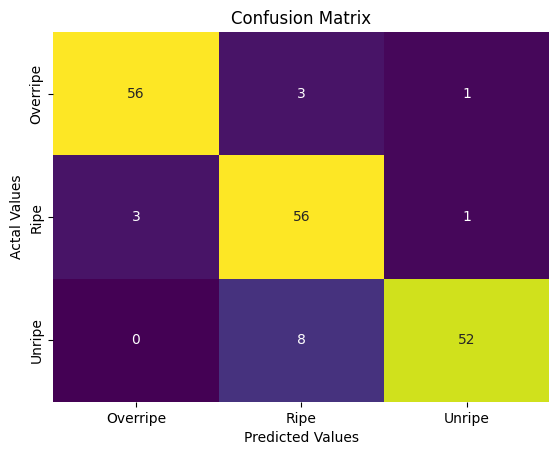

In [20]:
visualizer.show_confusion_matrix(test_gen.labels, y_pred_inception.argmax(axis=1), labels=test_gen.class_indices.keys())

In [21]:
visualizer.show_classification_report(test_gen.labels, y_pred_inception.argmax(axis=1), test_gen.class_indices.keys())

Classification Report

              precision    recall  f1-score   support

    Overripe       0.95      0.93      0.94        60
        Ripe       0.84      0.93      0.88        60
      Unripe       0.96      0.87      0.91        60

    accuracy                           0.91       180
   macro avg       0.92      0.91      0.91       180
weighted avg       0.92      0.91      0.91       180



### 7.2 VGG 19 Pretrained

In [22]:
y_pred_vgg = vgg_model.predict(test_gen)

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 


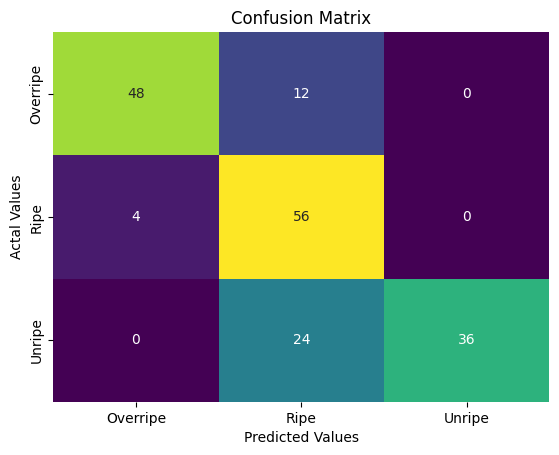

In [23]:
visualizer.show_confusion_matrix(test_gen.labels, y_pred_vgg.argmax(axis=1), labels=test_gen.class_indices.keys())

In [24]:
visualizer.show_classification_report(test_gen.labels, y_pred_vgg.argmax(axis=1), test_gen.class_indices.keys())

Classification Report

              precision    recall  f1-score   support

    Overripe       0.92      0.80      0.86        60
        Ripe       0.61      0.93      0.74        60
      Unripe       1.00      0.60      0.75        60

    accuracy                           0.78       180
   macro avg       0.84      0.78      0.78       180
weighted avg       0.84      0.78      0.78       180



### 7.3 Xception Pretrained

In [25]:
y_pred_xception = xception_model.predict(test_gen)

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step 


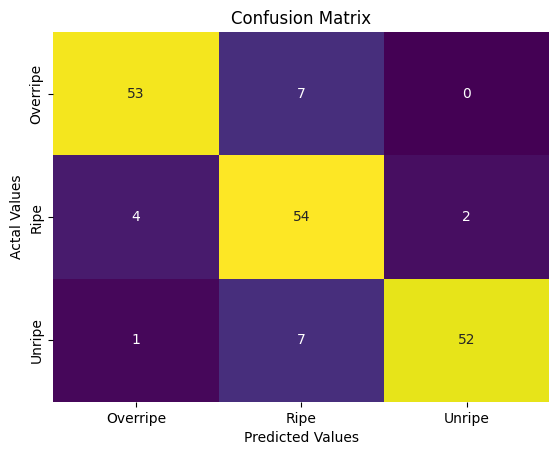

In [26]:
visualizer.show_confusion_matrix(test_gen.labels, y_pred_xception.argmax(axis=1), labels=test_gen.class_indices.keys())

In [27]:
visualizer.show_classification_report(test_gen.labels, y_pred_xception.argmax(axis=1), test_gen.class_indices.keys())

Classification Report

              precision    recall  f1-score   support

    Overripe       0.91      0.88      0.90        60
        Ripe       0.79      0.90      0.84        60
      Unripe       0.96      0.87      0.91        60

    accuracy                           0.88       180
   macro avg       0.89      0.88      0.88       180
weighted avg       0.89      0.88      0.88       180



## 8. Save Model

In [29]:
inception_model.save(f'/kaggle/working/inception_224_001_32_20.keras')
vgg_model.save(f'/kaggle/working/vgg__224_001_32_20.keras')
xception_model.save(f'/kaggle/working/xception__224_001_32_20.keras')